In [2]:
!pip install transformers --quiet

### Import Required Libraries

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW

import re
import string
import nltk
from nltk.corpus import stopwords

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Import and Preprocess Dataset

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import os
os.chdir("/kaggle/input/sentiment-analysis-dataset")

In [6]:
df = pd.read_csv(r"train.csv", encoding="latin1")
df_test = pd.read_csv(r"test.csv", encoding = "latin1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [8]:
## drop the null values from the train dataset
df.dropna(subset = ["text"], inplace = True)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [10]:
df_test["text"].isnull().sum()

1281

In [11]:
## drop the null values from the test dataset
df_test.dropna(inplace=True)

In [12]:
# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical form
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])
df_test["sentiment"] = label_encoder.transform(df_test["sentiment"])

df = df[["text","sentiment"]]
df_test = df_test[["text","sentiment"]]

df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [13]:
df["sent_lengths"] = df["text"].apply(lambda x: len(x.split(" ")))
df_test["sent_lengths"] = df_test["text"].apply(lambda x: len(x.split(" ")))

In [14]:
df.describe()

,sentiment,sent_lengths
count,27480.000000,27480.000000
mean,1.029148,13.779913
std,0.771118,7.169690
min,0.000000,1.000000
25%,0.000000,8.000000
50%,1.000000,13.000000
75%,2.000000,19.000000
max,2.000000,101.000000


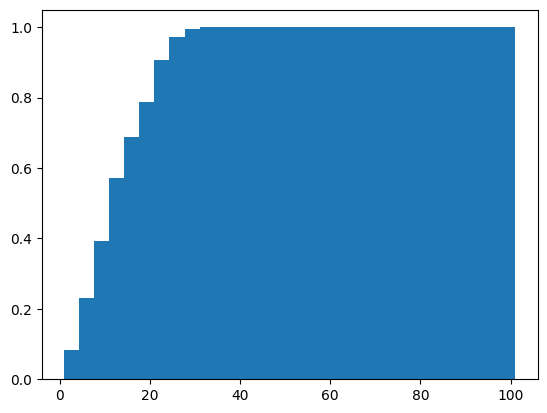

In [15]:
plt.hist(df["sent_lengths"], bins = 30, cumulative=True, density=True)
plt.show()

In [16]:
max_text_len  = int(df["sent_lengths"].quantile(0.995))
print("The 99.5 percentile of text length is", max_text_len)

The 99.5 percentile of text length is 30


In [17]:
print("Number of text with length more than {} in train data".format(max_text_len))
sum(df["sent_lengths"] > max_text_len)

Number of text with length more than 30 in train data


121

In [18]:
print("Number of text with length more than {} in test data".format(max_text_len))
sum(df_test["sent_lengths"] > max_text_len)

Number of text with length more than 30 in test data


12

In [19]:
# removing the sentences whose length is more than 31. so we will lose around 95 data points
df = df[df["sent_lengths"] <= max_text_len]
df_test = df_test[df_test["sent_lengths"] <= max_text_len]
df.shape

(27359, 3)

In [20]:
df["sentiment"].value_counts()

sentiment
1    11068
2     8552
0     7739
Name: count, dtype: int64

In [21]:
# converting the strings into lower case.
df["text"] = df["text"].apply(str.lower)
df_test["text"] = df_test["text"].apply(str.lower)

In [22]:
# dropping the sentence length column from dataframe
df.drop(["sent_lengths"], axis = 1, inplace = True)
df_test.drop(["sent_lengths"], axis = 1, inplace = True)

#### Split train, test and validation sets

In [23]:
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['sentiment'],
                                                                    random_state=8522,
                                                                    test_size=0.3,
                                                                    stratify=df['sentiment'])
test_text, test_labels = df_test["text"], df_test["sentiment"]

### Import BERT pretrained model

In [24]:
# import BERT-base pretrained model
bert = BertModel.from_pretrained("bert-base-uncased")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [25]:
bert = bert.to(device)

#### Tokenize and Encode the text

In [26]:
# tokenize and encode the text in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_text_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode the text in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_text_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode the text in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_text_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

#### Convert Integer text to tensor

In [27]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

#### Create Dataloaders

In [28]:
#define a batch size
batch_size = 32

## For train data
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

## For test data
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

#### Freeze BERT parameters

In [29]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [30]:
bert.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Define Model Architecture

In [31]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2
        self.fc2 = nn.Linear(512,256)

        # dense layer 3
        self.fc3 = nn.Linear(256, 64)

        # dense layer 4 (Output layer)
        self.fc4 = nn.Linear(64,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # Pass the inputs to the model
        output = self.bert(sent_id, attention_mask=mask)

        # Extract the last hidden states and the pooler_output from the model's output
        last_hidden_state, pooler_output = output.last_hidden_state, output.pooler_output

        x = self.fc1(pooler_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc4(x)

        # Apply softmax activation
        x = self.softmax(x)

        return x

In [32]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [33]:
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [34]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = F.cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [35]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 100 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            # elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = F.cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

### Model Training

In [36]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 25
early_stopping_patience = 3  # Number of epochs to wait before stopping if validation loss doesn't improve
no_improvement_counter = 0  # Counter to track epochs with no improvement

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/kaggle/working/saved_weights.pt')
        no_improvement_counter = 0  # Reset the counter if there's an improvement
    else:
        no_improvement_counter += 1

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # # Check if validation loss hasn't improved for a certain number of epochs
    # if no_improvement_counter >= early_stopping_patience:
    #     print(f'\nValidation loss has not improved for {early_stopping_patience} epochs. Early stopping...')
    #     break  # Stop training


 Epoch 1 / 25
  Batch   100  of    599.
  Batch   200  of    599.
  Batch   300  of    599.
  Batch   400  of    599.
  Batch   500  of    599.

Evaluating...
  Batch   100  of    257.
  Batch   200  of    257.

Training Loss: 1.065
Validation Loss: 1.030

 Epoch 2 / 25
  Batch   100  of    599.
  Batch   200  of    599.
  Batch   300  of    599.
  Batch   400  of    599.
  Batch   500  of    599.

Evaluating...
  Batch   100  of    257.
  Batch   200  of    257.

Training Loss: 0.968
Validation Loss: 0.905

 Epoch 3 / 25
  Batch   100  of    599.
  Batch   200  of    599.
  Batch   300  of    599.
  Batch   400  of    599.
  Batch   500  of    599.

Evaluating...
  Batch   100  of    257.
  Batch   200  of    257.

Training Loss: 0.933
Validation Loss: 0.896

 Epoch 4 / 25
  Batch   100  of    599.
  Batch   200  of    599.
  Batch   300  of    599.
  Batch   400  of    599.
  Batch   500  of    599.

Evaluating...
  Batch   100  of    257.
  Batch   200  of    257.

Training Loss: 0

In [37]:
#load weights of best model
path = '/kaggle/working/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Get predictions for test data

In [38]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [40]:
preds = np.argmax(preds, axis = 1)
test_y = label_encoder.inverse_transform(test_y)
preds = label_encoder.inverse_transform(preds)

#### Classification Report

In [41]:
# model's performance
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

    negative       0.69      0.55      0.61       999
     neutral       0.59      0.67      0.63      1425
    positive       0.67      0.66      0.67      1098

    accuracy                           0.64      3522
   macro avg       0.65      0.63      0.64      3522
weighted avg       0.64      0.64      0.64      3522



#### Confusion Matrix

In [42]:
pd.crosstab(test_y, preds)

col_0,negative,neutral,positive
row_0,,,
negative,549,352,98
neutral,196,961,268
positive,51,317,730
